In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import date
import pandas_datareader as web
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
warnings.filterwarnings("ignore")

In [2]:
def match_date(start, end, data):
    data.date = pd.to_datetime(data.date)
    data = data[(data['date'] >= start) & (data['date'] <= end)]
    data["date"] = data["date"].apply(lambda x: pd.to_datetime(x, unit="ns", utc=True).floor('D').date())
    #data.columns = data.columns.str.replace('Date', 'date')
    return data

In [3]:
start = dt.datetime(2022,3,9)
end = dt.datetime(2022,4,25)

GST = web.DataReader('GST2-USD','yahoo', start, end)
GMT = web.DataReader('GMT3-USD','yahoo', start, end)
GST = GST.reset_index()
GMT = GMT.reset_index()
GST.columns = GST.columns.str.replace('Date', 'date')
GMT.columns = GMT.columns.str.replace('Date', 'date')
GST = match_date(start, end, GST)
GMT = match_date(start, end, GMT)

#add pct change column
ClosingPrice = GST[['Adj Close']]
GST['pct_change'] = ClosingPrice.pct_change()*100
#add pct change column
ClosingPrice = GMT[['Adj Close']]
GMT['pct_change'] = ClosingPrice.pct_change()*100

GST["date"] = GST["date"].apply(lambda x: pd.to_datetime(x, unit="ns", utc=True).floor('D').date())
GST = GST.set_index('date')

In [4]:
def sentiment_groupby_day(data):
    data.drop(columns=data.columns[0], axis=1, inplace=True)
    data.drop(columns=data.columns[0], axis=1, inplace=True)
    data.drop(columns=data.columns[1], axis=1, inplace=True)
    data = data.groupby(['date'])['sentiment_score'].mean().reset_index().rename(columns={'mean':'sentiment score'})
    data = data.set_index('date') 
    
    data = data.sort_index() # sort by datetime
    return data

In [5]:
def filter_news_sentiment(start, end, data):
    data["date"] = data["date"].apply(lambda x: pd.to_datetime(x, unit="ns", utc=True).floor('D').date())
    crypto_news = data[(data['category'] == 'Cryptocurrencies')].reset_index()
    stocks_market_news = data[(data['category'] == 'Stock Market')].reset_index()
    finance_news = data[(data['category'] == 'Finance')].reset_index()
    #metaverse_news = data[(data['category'] == 'Metaverse')].reset_index()
    
    crypto_news = split_news_category(crypto_news)
    stocks_market_news = split_news_category(stocks_market_news)
    finance_news = split_news_category(finance_news)
    #metaverse_news = split_news_category(metaverse_news, remove_pos_bias, remove_neg_bias)
    
    return crypto_news,stocks_market_news,finance_news

In [6]:
def split_news_category(data):
    #group daily sentiment score
    data = data.drop(['content'], axis=1)
    data = data.groupby(['date'])['sentiment_score'].mean().reset_index().rename(columns={'mean':'sentiment score'})
    data = data.set_index('date') 
    data = data.sort_index() # sort by datetime
    data = data.reset_index()
    
    data = data.set_index('date')
    return data

In [7]:
news = pd.read_csv(r"data/News_sentiment.csv", sep="\t")
stepn_announcement = pd.read_csv(r"data/STEPN_Announcement_sentiment.csv", sep="\t")
stepn_general = pd.read_csv(r"data/STEPN_General_sentiment.csv", sep="\t")

In [8]:
crpto_news, stocks_market_news, finance_news = filter_news_sentiment(start, end, news)

In [9]:
stepn_announcement_by_day = sentiment_groupby_day(match_date(start, end, stepn_announcement))
stepn_general_by_day = sentiment_groupby_day(match_date(start, end, stepn_general))

In [10]:
crpto_news.columns = crpto_news.columns.str.replace('sentiment_score','crypto_sentiment_score') 
stocks_market_news.columns = stocks_market_news.columns.str.replace('sentiment_score','stock_market_sentiment_score') 
finance_news.columns = finance_news.columns.str.replace('sentiment_score','finance_sentiment_score') 
stepn_announcement_by_day.columns = stepn_announcement_by_day.columns.str.replace('sentiment_score','announcement_sentiment_score') 
stepn_general_by_day.columns = stepn_general_by_day.columns.str.replace('sentiment_score','general_sentiment_score') 

In [11]:
GST = GST.join(crpto_news)
GST = GST.join(stocks_market_news)
GST = GST.join(finance_news)
GST = GST.join(stepn_announcement_by_day)
GST = GST.join(stepn_general_by_day)
GST = GST.fillna(0)

In [12]:
GMT = GMT.join(crpto_news)
GMT = GMT.join(stocks_market_news)
GMT = GMT.join(finance_news)
GMT = GMT.join(stepn_announcement_by_day)
GMT = GMT.join(stepn_general_by_day)
GMT = GMT.fillna(0)

In [13]:
def add_freq(idx, freq=None):
    """Add a frequency attribute to idx, through inference or directly.

    Returns a copy.  If `freq` is None, it is inferred.
    """

    idx = idx.copy()
    if freq is None:
        if idx.freq is None:
            freq = pd.infer_freq(idx)
        else:
            return idx
    idx.freq = pd.tseries.frequencies.to_offset(freq)
    if idx.freq is None:
        raise AttributeError('no discernible frequency found to `idx`.  Specify'
                             ' a frequency string with `freq`.')
    return idx

In [14]:
GST_Data = GST.reset_index()
# Select only the important features
GST_Data = GST_Data[["date","Adj Close", "crypto_sentiment_score",
               "stock_market_sentiment_score","finance_sentiment_score",
                "announcement_sentiment_score","general_sentiment_score"
               ]] # select date and price
#GST_Data["date"] = GST_Data["date"].apply(lambda x: pd.to_datetime(x, unit="ns", utc=True))
GST_Data["date"] = GST_Data["date"].apply(lambda x: pd.to_datetime(x, unit="ns", utc=True).floor('D').date())
GST_Data = GST_Data.set_index(pd.DatetimeIndex(GST_Data['date']))
GST_Data = GST_Data.sort_index().asfreq('D')
GST_Data = GST_Data.drop(['date'], axis=1)

In [15]:
GMT_Data = GMT.reset_index()
# Select only the important features
GMT_Data = GMT_Data[["date","Adj Close", "crypto_sentiment_score",
               "stock_market_sentiment_score","finance_sentiment_score",
                "announcement_sentiment_score","general_sentiment_score"
               ]] # select date and price
#GST_Data["date"] = GST_Data["date"].apply(lambda x: pd.to_datetime(x, unit="ns", utc=True))
GMT_Data["date"] = GMT_Data["date"].apply(lambda x: pd.to_datetime(x, unit="ns", utc=True).floor('D').date())
GMT_Data = GMT_Data.set_index(pd.DatetimeIndex(GMT_Data['date']))
GMT_Data = GMT_Data.sort_index().asfreq('D')
GMT_Data = GMT_Data.drop(['date'], axis=1)

# Predictive model - Light Gradient Booster (LGB)

In [16]:
from sktime.forecasting.base import ForecastingHorizon
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.forecasting.arima import ARIMA
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.model_selection import train_test_split
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    ForecastingRandomizedSearchCV,
    SlidingWindowSplitter,
)
from sktime.forecasting.compose import (
    TransformedTargetForecaster,
    make_reduction,
    MultiplexForecaster
)
from sktime.forecasting.compose._reduce import DirRecTabularRegressionForecaster 
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.utils.plotting import plot_series
from sktime.forecasting.trend import PolynomialTrendForecaster
import matplotlib.dates as mdates
from pickle import dump, load

In [17]:
y = GST_Data['Adj Close']
X = GST_Data[["finance_sentiment_score",
               "stock_market_sentiment_score",
               "announcement_sentiment_score"]]

y_train, y_test, X_train, X_test = temporal_train_test_split(y,X, test_size=0.3)

In [18]:
yGMT = GMT_Data['Adj Close']
XGMT = GMT_Data[["finance_sentiment_score",
               "stock_market_sentiment_score",
               "announcement_sentiment_score",
                "general_sentiment_score"]]

yGMT_train, yGMT_test, XGMT_train, XGMT_test = temporal_train_test_split(yGMT,XGMT, test_size=0.3)

Sktime provides PolynomialTrendForecaster for this purpose, which can be used to fit a polynomial trend. The forecast it generates can be in turn combined with forecasts from other components to generate a final forecast. To illustrate its effects, we can use Sktime’s Detrender which takes the Polynomial forecaster as input in order to detrend the Time Series. It returns the residuals after removing the trend generated by the Trend Forecaster. The trend generated can be seen in the yellow line in the below plot. As we see the residuals consist mostly of the Seasonal component.

In [19]:
def plot_detrender(y_train,y_test, X_train, X_test, title):
    #--------------------------Detrender-----------------------------
    #degree=1 for Linear
    forecaster = PolynomialTrendForecaster(degree=1) 
    transformer = Detrender(forecaster=forecaster)
    #Get the residuals after fitting a linear trend
    y_resid = transformer.fit_transform(y_train)
    # Internally, the Detrender uses the in-sample predictions
    # of the PolynomialTrendForecaster
    forecaster = PolynomialTrendForecaster(degree=1)
    fh_ins = -np.arange(len(y_train))  # in-sample forecasting horizon
    y_pred = forecaster.fit(y_train).predict(fh=fh_ins)

    fig, ax = plt.subplots(figsize=(20, 5))
    fig.suptitle(title, fontsize=16)
    # use formatters to specify major and minor ticks
    dateformat = mdates.DateFormatter("%d-%m-%Y")
    ax.xaxis.set_major_formatter(dateformat)
    ax.xaxis.set_minor_formatter(dateformat)
    _ = plt.xticks(rotation=45)
    plot_series(y_train, y_pred, y_resid, labels=["y_train", "fitted linear trend", "residuals"], ax=ax);

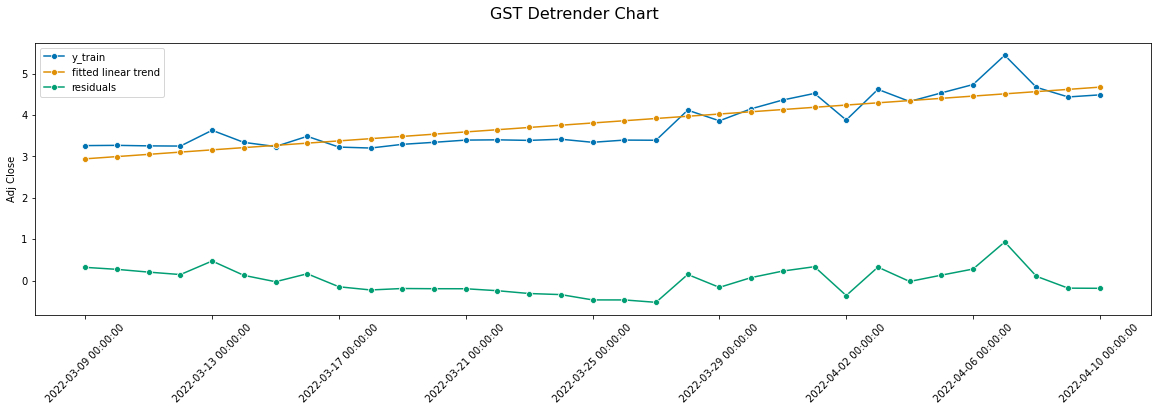

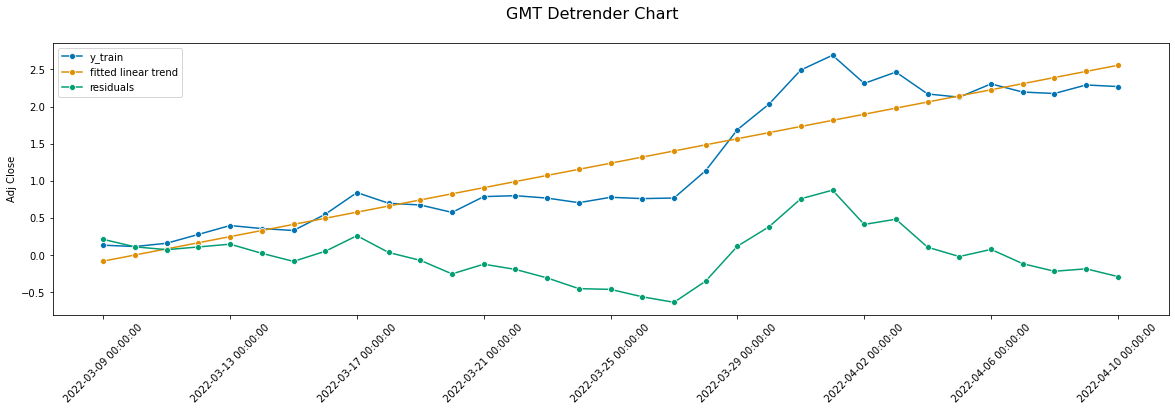

In [20]:
#Plot for GST
plot_detrender(y_train, y_test, X_train, X_test, "GST Detrender Chart")
#Plot for GMT
plot_detrender(yGMT_train, yGMT_test, XGMT_train, XGMT_test, "GMT Detrender Chart")

In [74]:
#----------------------------Create Pipeline--------------------
def get_transformed_target_forecaster(alpha,params, fh):
    
    #Initialize Light GBM Regressor 
    
    regressor = lgb.LGBMRegressor(alpha = alpha,**params)
#-----------------------Forecaster Pipeline-----------------
    
    #1.Separate the Seasonal Component.
    #2.Fit a forecaster for the trend.
    #3.Fit a Autoregressor to the resdiual(autoregressing on four historic values).

    forecaster = TransformedTargetForecaster(
        [
            ("deseasonalise", Deseasonalizer(model="multiplicative", sp=7)),
            ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
            (
                # Recursive strategy for Multi-Step Ahead Forecast.
                # Auto Regress on four previous values
                "forecast", make_reduction(regressor, window_length=7,                               
                strategy="recursive") #hyper-paramter to set recursive strategy)
            )
        ])
    

    return forecaster

In [75]:
def train_predict_model(crypto, y_train, y_test, X_train, X_test, data, title):
    #-------------------Fitting an Auto Regressive Light-GBM------------
    #Setting Quantile Regression Hyper-parameter.
    params = {
        'objective':'quantile'
    }
    #A 10 percent and 90 percent prediction interval(0.1,0.9 respectively).
    quantiles = [.1, .5, .9] #Hyper-parameter "alpha" in Light GBM
    #Capture forecasts for 10th/median/90th quantile, respectively.
    forecasts = []
    #Iterate for each quantile.
    for alpha in quantiles:
        #Initialize ForecastingHorizon class to specify the horizon of forecast
        fh = ForecastingHorizon(X_test.index, is_relative=False)
        forecaster = get_transformed_target_forecaster(alpha,params, fh)
    
        #print(fh)
        #Fit on Training data.
        forecaster.fit(y_train.asfreq('D'), X_train.asfreq('D'))
        dump(forecaster,open('Models/predictive/{1}_q_{0}_model.pkl'.format(alpha, crypto),'wb'))
    
        #Forecast the values.
        y_pred = forecaster.predict(fh, X_test)
    
        #List of forecasts made for each quantile.
        y_pred.index.name="date"
        y_pred.name=f"predicted_price_q_{alpha}"
        mape = mean_absolute_percentage_error(y_test, y_pred, symmetric=False)
        print('[{2}] {0}: {1} value of MAPE'.format(y_pred.name,mape, crypto))
        
        
        fig, ax = plt.subplots(figsize=(20, 5))
        fig.suptitle("{1}: Quantile {0}".format(alpha,title), fontsize=16)
        
        # use formatters to specify major and minor ticks
        dateformat = mdates.DateFormatter("%d-%m-%Y")
        ax.xaxis.set_major_formatter(dateformat)
        ax.xaxis.set_minor_formatter(dateformat)
        _ = plt.xticks(rotation=45) 
       
        plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], ax=ax) 
        forecasts.append(y_pred)
    
    #Append the actual data for plotting.
    data.index.name = "date"
    data.name = "Actual"
    forecasts.append(data)

    predicted_result = pd.concat(forecasts,axis=1)
    predicted_result.index = predicted_result.index.set_names("date")
    return predicted_result, forecaster

[GST] predicted_price_q_0.1: 0.05712280524829896 value of MAPE
[GST] predicted_price_q_0.5: 0.08430374987585218 value of MAPE
[GST] predicted_price_q_0.9: 0.15244796915678374 value of MAPE


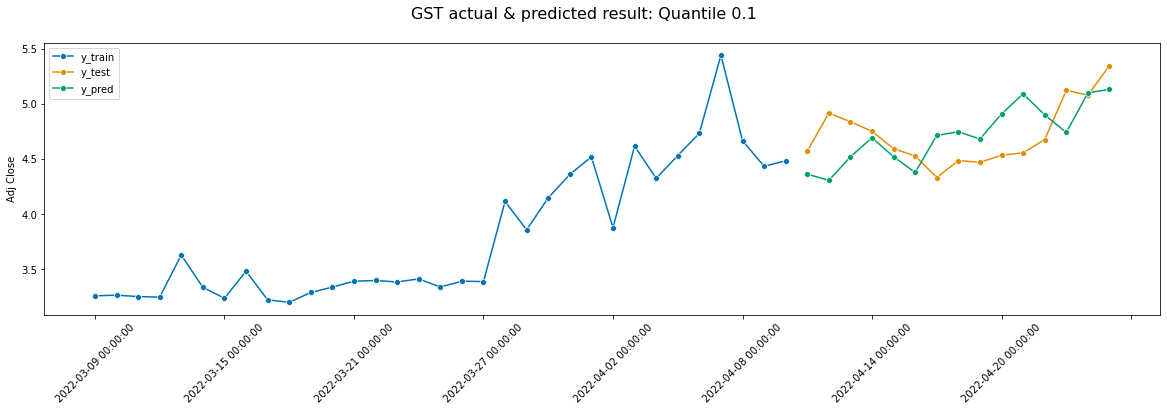

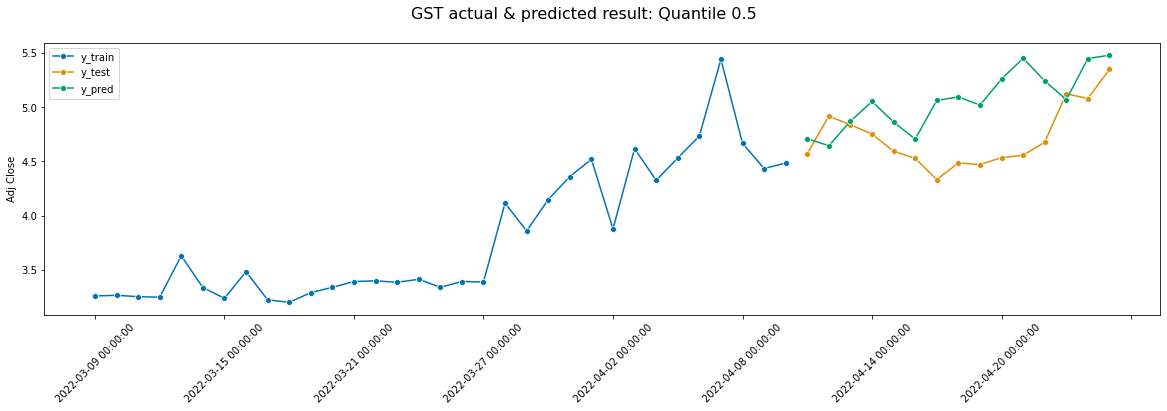

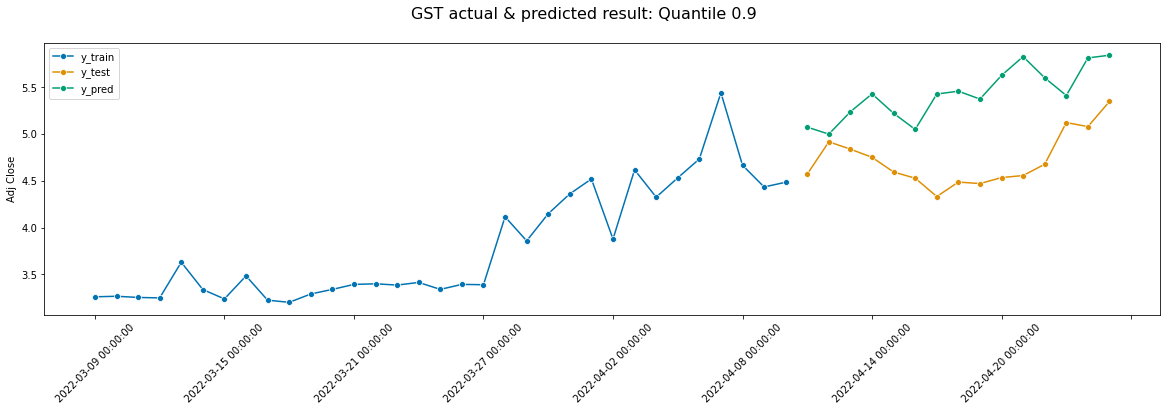

In [76]:
gst_result, GST_forecaster = train_predict_model("GST", y_train, y_test, X_train, X_test, GST_Data, "GST actual & predicted result")

[GMT] predicted_price_q_0.1: 0.11212127528988057 value of MAPE
[GMT] predicted_price_q_0.5: 0.17151327848427905 value of MAPE
[GMT] predicted_price_q_0.9: 0.3595119117210081 value of MAPE


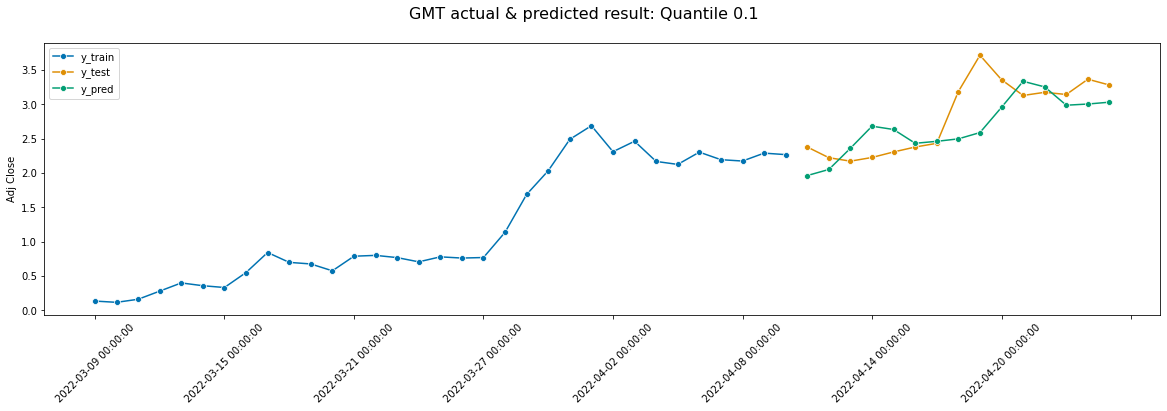

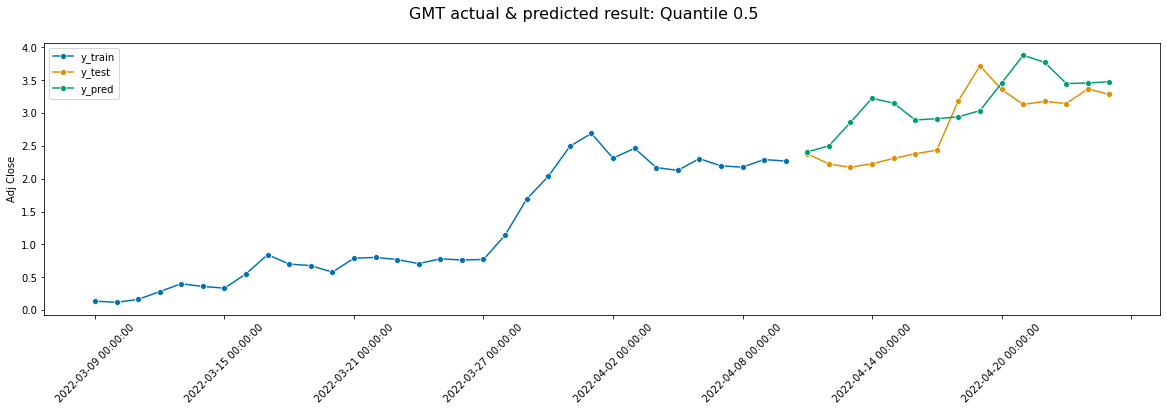

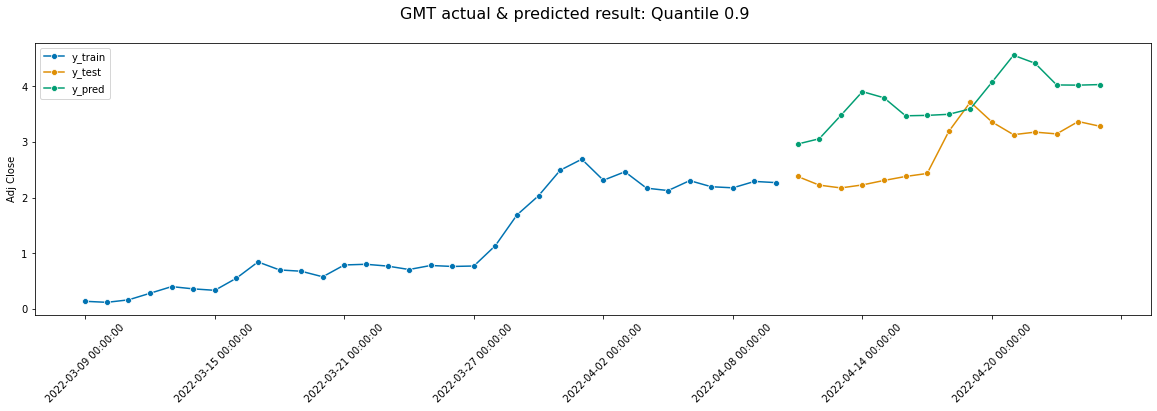

In [24]:
gmt_result, GMT_forecaster = train_predict_model("GMT", yGMT_train, yGMT_test, XGMT_train, XGMT_test, GMT_Data, "GMT actual & predicted result")

# Cross Validate

In [28]:
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.model_evaluation import evaluate

In [69]:
def cross_validate_model(forecaster, y, X, title):
    cv = ExpandingWindowSplitter(step_length=7, fh=list(range(1,7)), initial_window=14)
    cv_df = evaluate(forecaster=forecaster, y=y, cv=cv, X=X, strategy="refit", return_data=True)

    fig, ax = plt.subplots(figsize=(20, 5))
    fig.suptitle("Evaluate {0} cross validate model".format(title), fontsize=16)
        
    # use formatters to specify major and minor ticks
    _ = plt.xticks(rotation=45) 
        
    plot_series(
        y, *[cv_df["y_pred"].iloc[x] for x in range(5)],
        markers=["o", *["."]*5],
        labels=["Actual"] + [f"Cross validate: {x}" for x in range(5)], ax=ax
    );

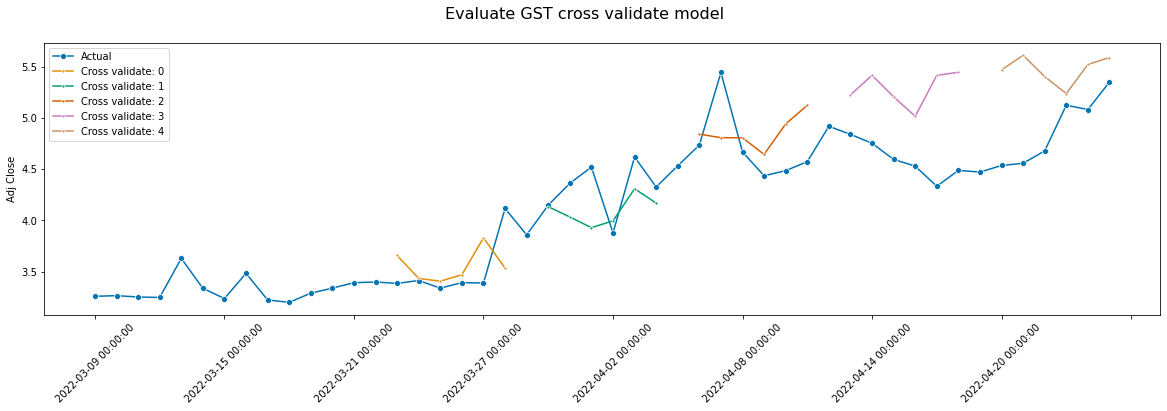

In [70]:
cross_validate_model(GST_forecaster, y, X, "GST")

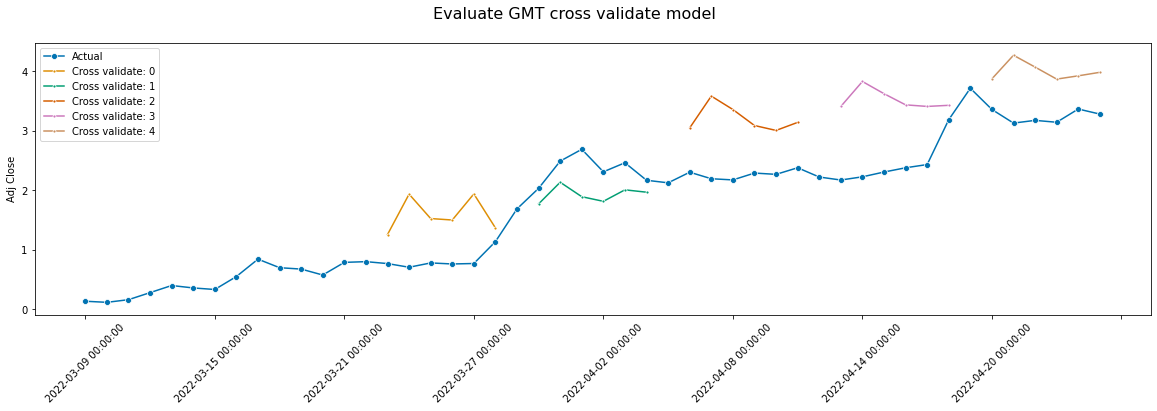

In [52]:
cross_validate_model(GMT_forecaster, yGMT, XGMT, "GMT")

# Plot forecast with quantiles (predict interval) of 0.1, 0.5 and 0.9

In [25]:
def plot_forecast(predicted_result, title):
    #-------------------Final Plotting of Forecasts------------------
    plot_data = pd.melt(predicted_result.reset_index(), id_vars=['date'],\
                    value_vars=['predicted_price_q_0.1', 'predicted_price_q_0.5',
                    'predicted_price_q_0.9','Adj Close'])
    plot_data['date'] = pd.to_datetime(plot_data['date'].astype(str).to_numpy())

    fig, ax = plt.subplots(figsize=(20, 5))
    sns.lineplot(data = plot_data,
        x='date',
        y='value',
        markers=['o','o'],
    )

    plt.title("{0} Final Forecast".format(title))
    plt.show()

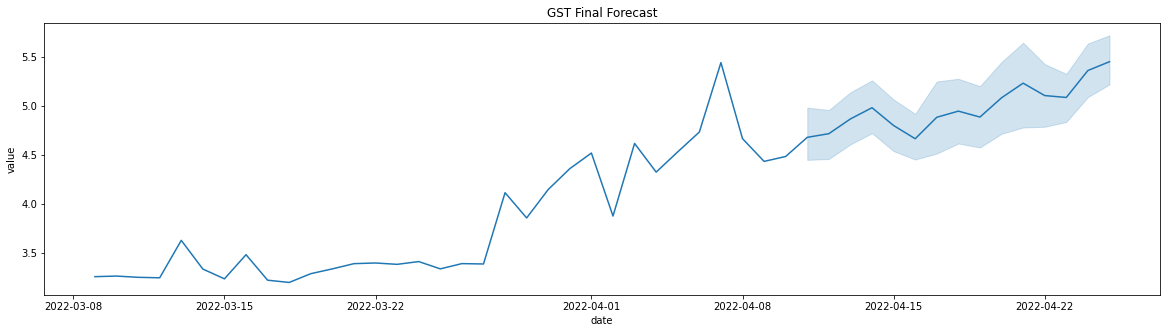

In [26]:
plot_forecast(gst_result, "GST")

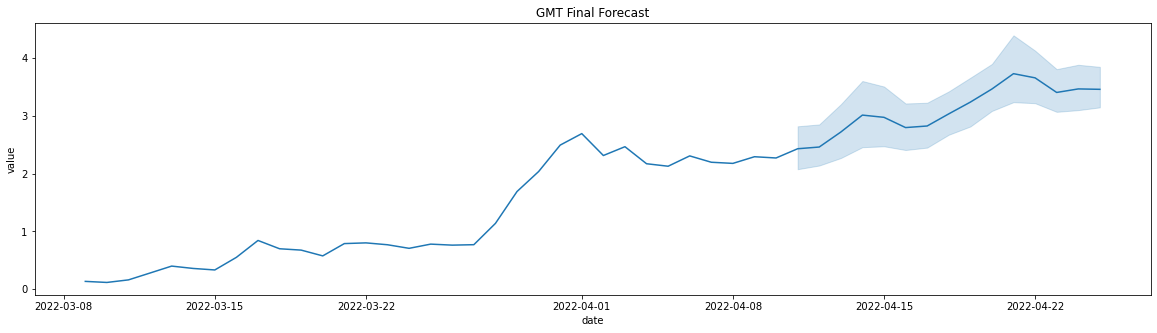

In [27]:
plot_forecast(gmt_result, "GMT")

# Test new data

In [28]:
start = dt.datetime(2022,4,26)
end = dt.datetime(2022,4,27)

news = pd.read_csv(r"data/New_News_sentiment.csv", sep="\t")
stepn_announcement = pd.read_csv(r"data/new_STEPN_Announcement_sentiment.csv", sep="\t")
stepn_general = pd.read_csv(r"data/new_STEPN_General_sentiment.csv", sep="\t")

crpto_news, stocks_market_news, finance_news = filter_news_sentiment(start, end, news)
stepn_announcement_by_day = sentiment_groupby_day(match_date(start, end, stepn_announcement))
stepn_general_by_day = sentiment_groupby_day(match_date(start, end, stepn_general))

stocks_market_news.columns = stocks_market_news.columns.str.replace('sentiment_score','stock_market_sentiment_score') 
finance_news.columns = finance_news.columns.str.replace('sentiment_score','finance_sentiment_score') 
stepn_announcement_by_day.columns = stepn_announcement_by_day.columns.str.replace('sentiment_score','announcement_sentiment_score') 
stepn_general_by_day.columns = stepn_announcement_by_day.columns.str.replace('sentiment_score','general_sentiment_score') 

newGST = stocks_market_news
newGST = newGST.join(finance_news)
newGST = newGST.join(stepn_announcement_by_day)
newGST = newGST.join(stepn_general_by_day)
newGST = newGST.fillna(0)

newGST_Data = newGST.reset_index()
# Select only the important features
newGST_Data = newGST_Data[["date",
               "stock_market_sentiment_score","finance_sentiment_score",
                "announcement_sentiment_score"
               ]] # select date and price
#GST_Data["date"] = GST_Data["date"].apply(lambda x: pd.to_datetime(x, unit="ns", utc=True))
newGST_Data["date"] = newGST_Data["date"].apply(lambda x: pd.to_datetime(x, unit="ns", utc=True).floor('D').date())
newGST_Data["Adj Close"] = 0
newGST_Data = newGST_Data.set_index(pd.DatetimeIndex(newGST_Data['date']))
newGST_Data = newGST_Data.drop(['date'], axis=1)
newGST_Data = newGST_Data.sort_index().asfreq('D').fillna(0)

In [29]:
def transform_sktime_index(data):
    data = data.fillna(0)
    data = data.reset_index()
    data = data.set_index(pd.DatetimeIndex(data['date']))
    data = data.sort_index().asfreq('D')
    data = data.drop(['date'], axis=1)
    data.index = add_freq(data.index, freq='D')
   
    return data

In [47]:
def predict_next(data, crypto, forecaster):
    #print(data)
    y = data[["Adj Close"]]
    X = data[["finance_sentiment_score",
               "stock_market_sentiment_score",
               "announcement_sentiment_score"]]
    y = transform_sktime_index(y)
    X = transform_sktime_index(X)
    
    #fh=ForecastingHorizon(X.index, is_relative=True)
    # load the model
    #model = load(open('Models/predictive/{0}_q_0.1_model.pkl'.format(crypto), 'rb'))
    #Initialize ForecastingHorizon class to specify the horizon of forecast
   
    forecaster = forecaster.update(y,update_params=False)
    y_pred = forecaster.predict(fh=5,X=X)
    
    return y_pred

In [48]:
y_pred = predict_next(newGST_Data.head(5), "GST",GST_forecaster)

In [49]:
y_pred

,Adj Close
2022-05-05,NaN


In [50]:
X_test

,finance_sentiment_score,stock_market_sentiment_score,announcement_sentiment_score
date,,,
2022-04-11,-0.025862,0.418366,0.033344
2022-04-12,-0.044267,0.244784,-0.105602
2022-04-13,0.077185,-0.004854,0.000000
2022-04-14,-0.105828,-0.137934,0.035383
2022-04-15,-0.097800,-0.404536,0.000000
2022-04-16,-0.068885,0.000000,0.055420
2022-04-17,-0.179000,0.172899,0.035353
2022-04-18,-0.148797,0.105290,-0.025857
2022-04-19,-0.183590,-0.064133,-0.046574


# Predictive Model - KNN, ARIMA, TBATS

In [ ]:
y = GST_Data['Adj Close']
X = GST_Data[["finance_sentiment_score",
               "stock_market_sentiment_score",
             "announcement_sentiment_score"]]

y_train, y_test, X_train, X_test = temporal_train_test_split(y,X, test_size=14)
fh = ForecastingHorizon(X_test.index, is_relative=False)

forecaster = MultiplexForecaster(
    forecasters=
    [
        (
            "KNN forecast",
            make_reduction(
                KNeighborsRegressor(),
                scitype="tabular-regressor",
                window_length=7,
                strategy="recursive",
            ),
        ),
        ("ARIMA", ARIMA()),
        ("TBATS", TBATS(sp=7, use_trend=True, use_box_cox=False))
    ],
)

cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5), window_length=14)
forecaster_param_grid = {"selected_forecaster": ["KNN forecast", "ARIMA","TBATS"]}
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid)
gscv.fit(y_train,X_train)
y_pred = gscv.predict(fh, X_test)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

In [ ]:
gscv.best_forecaster_

In [ ]:
gscv.best_params_

In [77]:
from sktime.datasets import load_macroeconomic
y = load_macroeconomic()

In [78]:
y

,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
Period,,,,,,,,,,,,
1959Q1,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1959Q2,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
1959Q3,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
1959Q4,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
1960Q1,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...
2008Q3,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
2008Q4,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
2009Q1,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
